## Import Libraries


In [45]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, datasets
from sklearn import svm
import scipy.signal as signal
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import LeavePOut
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Utilities functions for working with the dataset

In [2]:
def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
        
        
##
## This function reutrn a list of matrices. Each matrix correspond to a question instance in which each row is a channel, and in the coloumn it develop the signal in time
## The function also manage to standardize the time length
def channels_to_vector(channels): 
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


##
# Create the train data matrix
##
## usage
def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


### Description
def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
## description
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix


def get_accuracy(predicted_labels, true_labels):
     if (predicted_labels.size == true_labels.size):
        return  np.sum(predicted_labels ==  true_labels )/len( true_labels)

## EEG feature loading

Import data from previous analysis


In [3]:
#Import data from mat files
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')

channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

#Features Loading
features_extracted_yes   = sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no    = sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes = sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no  = sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']

channels_structure_yes_EEG = channels_to_vector(channels_yes_EEG)
channels_structure_no_EEG  = channels_to_vector(channels_no_EEG)

##Structuring of the data:
#the code below create the train matrix with respect to the signal given in "channel_structure" but using the features contained in "features_extracted*" and in "connettivity_feature*".
feature_dataset_yes_EEG, EEG_yes_labels = get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

feature_dataset_no_EEG, EEG_no_labels = get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);

#Merge the labeled data
feature_dataset_full = np.concatenate((feature_dataset_yes_EEG, feature_dataset_no_EEG), axis=0 )
labels = np.concatenate((EEG_yes_labels,EEG_no_labels), axis=0)


print("The dataset have shape:")
print(feature_dataset_full.shape)

The dataset have shape:
(60, 386)


## Leave One Out 

In [5]:
def get_accuracy(predicted_labels, true_labels):
     if (predicted_labels.size == true_labels.size):
        return  np.sum(predicted_labels ==  true_labels)/len(predicted_labels)
    
def get_accuracy_std(predicted_labels, true_labels):
     if (predicted_labels.size == true_labels.size):
        return  np.sum(predicted_labels ==  true_labels)
    
def leave_one_out(X, Y, classifier):
    svm_total_acc_test = []
    for i in range(X.shape[0]):
#SVM classifier definition
        i1 = [j for j in range(X.shape[0])]
        i1.remove(i)
        i2 = i
        train=X[i1,:]
        labels_train=Y[i1]

        test= X[i2,:]
        labels_test=Y[i2]
        clf_temp = classifier
        clf_temp.fit(train, labels_train)  

        #Accuracy on test
        predicted_labels_test = clf_temp.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))


def leave_one_out_std(X, Y, classifier):
    svm_total_acc_test = []
    for i in range(X.shape[0]):
        
#SVM classifier definition
        i1 = [j for j in range(X.shape[0])]
        i1.remove(i)
        i2 = i
        train=X[i1,:]
        labels_train=Y[i1]

        test = X[i2,:]
        labels_test=Y[i2]
        
        scaler = StandardScaler()
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        
        
        clf_temp = classifier
        clf_temp.fit(train, labels_train)  
        
        #Accuracy on test
        predicted_labels_test = clf_temp.predict(test)
        SVM_accuracy_test = get_accuracy_std(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))


def leave_two_out(X, Y, classifier):
    svm_total_acc_test = []
    for i in range(X.shape[0]):
        for l in range(X.shape[0]):
            if(i!=l):
                #scaler = StandardScaler()
        #SVM classifier definition
                i1 = [j for j in range(X.shape[0])]
                i1.remove(i)
                i2 = i
                train=X[i1,:]
                labels_train=Y[i1]

                test = X[i2,:]
                labels_test=Y[i2]


                #scaler.fit(train)
                #train = scaler.transform(train)
                #test = scaler.transform(test)


                clf_temp = classifier
                clf_temp.fit(train, labels_train)  

                #Accuracy on test
                predicted_labels_test = clf_temp.predict(test)
                SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
                svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))

def leave_two_out_sci(X, Y, classifier):
    svm_total_acc_test = []
    lpo = LeavePOut(2)
    
    for train_index, test_index in lpo.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
                #scaler = StandardScaler()
        
        clf_temp = classifier
        clf_temp.fit(X_train, y_train)  

                #Accuracy on test
        predicted_labels_test = clf_temp.predict(X_test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, y_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))



## Exploration of the best number of features

Only the top-k features that have the best ANOVA F-test Score are retained.
An hard-margin (C=1) SVM linear classifier is trained and its performances assessed with a full search leave-one-out

Might require some computational time (spoiler: best k seems to be 21)

In [94]:
tot_perf = []
end_feat = 100
for k in range(1,end_feat):
    print('progress: ' + str(k/300*100) + ' %')
    reducer = SelectKBest(f_classif, k)
    
    scaler2= StandardScaler()
    feat_std = scaler2.fit_transform(feature_dataset_full)
    feature_dataset_reduced = reducer.fit_transform(feat_std, labels)
    svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
    perf_temp = leave_two_out_sci(feat_std, labels, svc)
    tot_perf.append(perf_temp)

best_k = np.argmax(tot_perf)+1
print("smallest k that gives best Leave-one-out results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

progress: 0.33333333333333337 %


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


progress: 0.6666666666666667 %
progress: 1.0 %
progress: 1.3333333333333335 %
progress: 1.6666666666666667 %
progress: 2.0 %
progress: 2.3333333333333335 %
progress: 2.666666666666667 %
progress: 3.0 %
progress: 3.3333333333333335 %
progress: 3.6666666666666665 %
smallest k that gives best Leave-one-out results:
1

wich have lead to the top performance:
0.9731638418079096

index of features retained:
[292]


### Print of the results

In [83]:
best_k = np.argmax(tot_perf)+1
print("smallest k that gives best Leave-one-out results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

smallest k that gives best Leave-one-out results:
1

wich have lead to the top performance:
0.9666666666666667

index of features retained:
[292]


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [95]:
print(tot_perf)

[0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096, 0.9731638418079096]


# Evaluation of performances with varying size train/test

Definition of utilities functions

In [69]:
def classification_SVM_experiments(X, Y, classifier, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        
        clf = classifier
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train


def classification_SVM_experiments_std(X, Y, classifier, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        scaler = StandardScaler()
        
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        
        
        clf = classifier
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train

def performance_assesment_fraction(X, Y, num_experiment, classifier):
    fracs = np.linspace(0.2,0.9,25)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments(X, Y, classifier, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    #plot the figure
    plt.figure(figsize=(10, 7), dpi=80)
    plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
    plt.minorticks_on()
    plt.title('SVM perfomances over different train/test dataset of reduced features')
    plt.ylabel('Accuracy')
    plt.xlabel('Train/test fraction')

    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
    plt.show()
    
def performance_assesment_fraction_std(X, Y, num_experiment, classifier):
    fracs = np.linspace(0.2,0.9,25)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments_std(X, Y, classifier, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    #plot the figure
    plt.figure(figsize=(10, 7), dpi=80)
    plt.errorbar(np.floor(fracs*60), accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(np.floor(fracs*60), accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
    plt.minorticks_on()
    plt.title('SVM perfomances over different train/test dataset of reduced features')
    plt.ylabel('Accuracy')
    plt.xlabel('Train instances considered')

    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
    plt.show()

# Extra Tree Classifierz

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Evaluation progress: 0 %
Evaluation progress: 4 %
Evaluation progress: 8 %
Evaluation progress: 12 %
Evaluation progress: 16 %
Evaluation progress: 20 %
Evaluation progress: 25 %
Evaluation progress: 29 %
Evaluation progress: 33 %
Evaluation progress: 37 %
Evaluation progress: 41 %
Evaluation progress: 45 %
Evaluation progress: 50 %
Evaluation progress: 54 %
Evaluation progress: 58 %
Evaluation progress: 62 %
Evaluation progress: 66 %
Evaluation progress: 70 %
Evaluation progress: 74 %
Evaluation progress: 79 %
Evaluation progress: 83 %
Evaluation progress: 87 %
Evaluation progress: 91 %
Evaluation progress: 95 %
Evaluation progress: 100 %


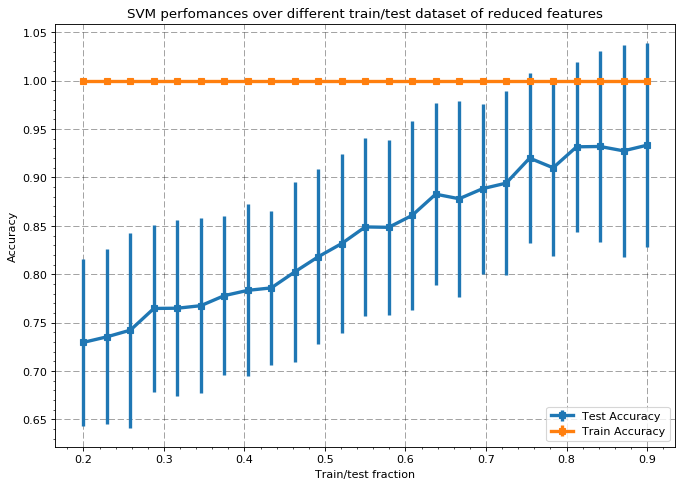

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

reducer = SelectKBest(f_classif, 61)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

X = feature_dataset_reduced
Y = labels
num_experiment = 50

#extra_tree = ExtraTreesClassifier()
extra_tree = ExtraTreesClassifier(n_estimators=100, max_features=None)

performance_assesment_fraction(X, Y, num_experiment, extra_tree)

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

X = feature_dataset_full
Y = labels
num_experiment = 50

#extra_tree = ExtraTreesClassifier()
extra_tree = ExtraTreesClassifier(n_estimators=10000, max_features=None, n_jobs=3)
extra_tree.fit(X, Y)

feat_import = extra_tree.feature_importances_
#print(feat_import)


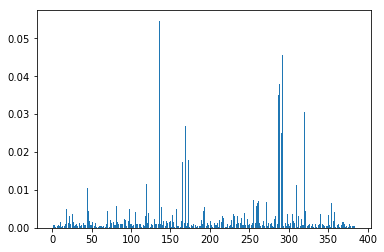

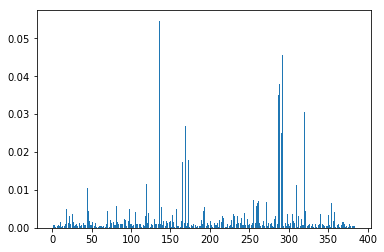

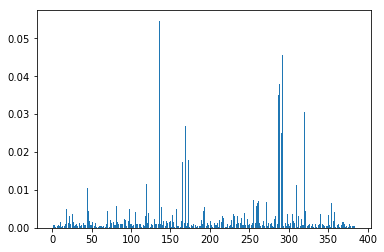

In [29]:
plt.figure()
plt.bar(range(len(feat_import)),feat_import)
plt.show()

In [43]:

features_tree = np.argsort(feat_import)
print(features_tree)
def get_k_feat_tree(k, data):
    idxs = features_tree[:k]
    idxs_sorted = np.sort(idxs)
    data_reduced = data[:,idxs_sorted]
    
    return data_reduced
    

[125 163 151 327 109 155 331 229   0 364 299  59  64 211 335 360 167 355
 174 359  73 372  68 220 281  12 203 311  77 376  56 183  72 221 113 303
 204   4 384 353 199 297 188 129 170  48 382 285 184 233 347 148 133 152
 187 102 348  60 264  32  28 166  57 178 380 105 345 269  85 329 351 180
 308 196  61  36 333   9  16  20  94 159 294 301 373 279 273 289  81 160
  63 247 383  43 171 257 293  90  44  13 117  52 315 378   7 225 144 381
 157 295  65  54 324 349   8 114   3 241 317 332  19 202 323 251 186  30
 249  37  50 140 328 309 226   2  42 325  33 367 319  49 265 243 205 344
 352 356 245  41 313  34 116 207 127 100  10 261  80  79   1   6 103 379
 208 177 156 176 266 182 267 362 123 238  53 198 338 162  38 374 253 179
 277 195 108  23 135  84 190   5 290  69 326 341  29 286 124  99 242 234
 131  88 200 366 132  24 142 363 222 107 250 185  87 232 330 181 126 219
 385 112 371 377 300  17 270 370 334 343  89 137 101 191 339 111  31 246
 254 194 210 104 278 239  55 296  75 197 346 138  4

In [42]:
get_k_feat_tree(3, feature_dataset_full)

array([[13.54031404, 14.76834761, 16.82400054],
       [14.21639598, 13.977724  , 17.46639409],
       [ 1.71303999,  6.39059792,  8.39296653],
       [ 1.50350842,  4.73568256,  5.62214252],
       [16.70726222, 13.84190687, 15.80826638],
       [16.07853006, 12.60705745, 16.33915732],
       [ 5.23500291,  9.07115714, 10.49632546],
       [ 5.06269589,  8.40528373,  9.12571421],
       [ 2.60174594,  7.21454665,  9.90178493],
       [ 2.88018486,  6.56168963,  8.30465457],
       [ 4.21305296,  7.22247915,  7.69068059],
       [ 3.40062311,  7.357     ,  8.54725417],
       [ 2.87786169,  6.22106907,  7.05289469],
       [ 2.73693772,  6.90228436,  7.73939298],
       [ 1.74929024,  6.34407056,  6.94566686],
       [ 1.51625767,  5.73383084,  8.06302274],
       [ 3.32296824,  6.89988651,  8.50927228],
       [ 3.32365296,  6.44329948,  7.00090609],
       [ 1.88842795,  5.61321635,  6.67072753],
       [ 1.7233625 ,  5.9181767 ,  7.93374336],
       [ 1.70279807,  5.80727713,  7.226

In [56]:
tot_perf = []
end_feat = 100
fraction_train_test = 0.2
num_experiments = 1000


for k in range(1,end_feat):
    print('progress: ' + str(k/end_feat*100) + ' %')
    
    
    scaler2= StandardScaler()
    feat_std = scaler2.fit_transform(feature_dataset_full)
    
    feature_dataset_reduced = get_k_feat_tree(k, feature_dataset_full)
    
    
    svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
    
    #perf_temp = leave_two_out_sci(feat_std, labels, svc)
    perf_temp = classification_SVM_experiments_std(feature_dataset_reduced, labels, svc, fraction_train_test, num_experiments)
    tot_perf.append(perf_temp)
    #print(perf_temp)

best_k = np.argmax(tot_perf)+1
print("smallest k that gives best Leave-one-out results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

progress: 1.0 %
progress: 2.0 %
progress: 3.0 %
progress: 4.0 %
progress: 5.0 %
progress: 6.0 %
progress: 7.000000000000001 %
progress: 8.0 %
progress: 9.0 %
progress: 10.0 %
progress: 11.0 %
progress: 12.0 %
progress: 13.0 %
progress: 14.000000000000002 %
progress: 15.0 %
progress: 16.0 %
progress: 17.0 %
progress: 18.0 %
progress: 19.0 %
progress: 20.0 %
progress: 21.0 %
progress: 22.0 %
progress: 23.0 %
progress: 24.0 %
progress: 25.0 %
progress: 26.0 %
progress: 27.0 %
progress: 28.000000000000004 %
progress: 28.999999999999996 %
progress: 30.0 %
progress: 31.0 %
progress: 32.0 %
progress: 33.0 %
progress: 34.0 %
progress: 35.0 %
progress: 36.0 %
progress: 37.0 %
progress: 38.0 %
progress: 39.0 %
progress: 40.0 %
progress: 41.0 %
progress: 42.0 %
progress: 43.0 %
progress: 44.0 %
progress: 45.0 %
progress: 46.0 %
progress: 47.0 %
progress: 48.0 %
progress: 49.0 %
progress: 50.0 %
progress: 51.0 %
progress: 52.0 %
progress: 53.0 %
progress: 54.0 %
progress: 55.00000000000001 %
progr

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Evaluation progress: 0 %
Evaluation progress: 4 %
Evaluation progress: 8 %
Evaluation progress: 12 %
Evaluation progress: 16 %
Evaluation progress: 20 %
Evaluation progress: 25 %
Evaluation progress: 29 %
Evaluation progress: 33 %
Evaluation progress: 37 %
Evaluation progress: 41 %
Evaluation progress: 45 %
Evaluation progress: 50 %
Evaluation progress: 54 %
Evaluation progress: 58 %
Evaluation progress: 62 %
Evaluation progress: 66 %
Evaluation progress: 70 %
Evaluation progress: 74 %
Evaluation progress: 79 %
Evaluation progress: 83 %
Evaluation progress: 87 %
Evaluation progress: 91 %
Evaluation progress: 95 %
Evaluation progress: 100 %


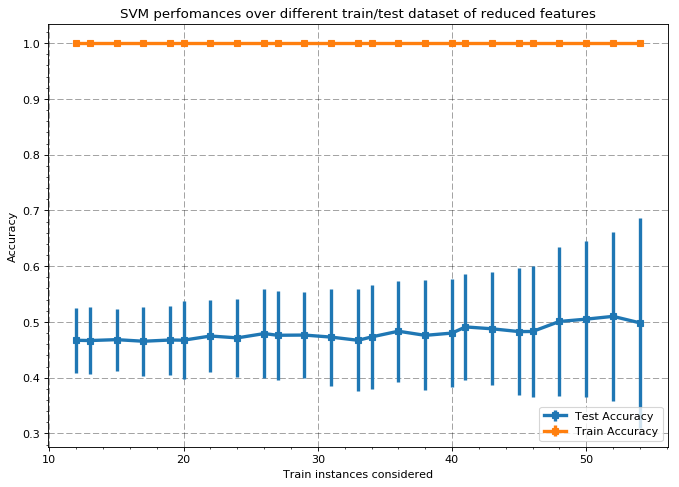

In [70]:
feature_dataset_reduced = get_k_feat_tree(k, feature_dataset_full)
X = feature_dataset_reduced
Y = labels
num_experiment = 50


svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)

performance_assesment_fraction_std(X, Y, 100, svc)
